In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Data Loading 

In [2]:
sales_df = pd.read_csv('../../datasets/predict-sales/sales_train.csv')
items_df = pd.read_csv('../../datasets/predict-sales/items.csv')
test_df = pd.read_csv('../../datasets/predict-sales/test.csv')

In [3]:
sales_df.drop(labels=['date'],inplace=True,axis=1)
sales_df = sales_df.reset_index()
items_df.drop(labels=['item_name'],inplace=True,axis=1)

In [4]:
sales_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2935849 entries, 0 to 2935848
Data columns (total 6 columns):
index             int64
date_block_num    int64
shop_id           int64
item_id           int64
item_price        float64
item_cnt_day      float64
dtypes: float64(2), int64(4)
memory usage: 134.4 MB


In [5]:
sales_df.head()

,index,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,0,0,59,22154,999.00,1.0
1,1,0,25,2552,899.00,1.0
2,2,0,25,2552,899.00,-1.0
3,3,0,25,2554,1709.05,1.0
4,4,0,25,2555,1099.00,1.0


# Visualizing Data 

Let's visualize some data from the test set:

In [6]:
def drawTimeSerie(df, sample, n):
    for i in range(n):
        shop_id = sample.iloc[i]['shop_id']
        item_id = sample.iloc[i]['item_id']
        id_df = df[(df['shop_id'] == shop_id) & (df['item_id'] == item_id)]
        id_df_grouped = id_df[['date_block_num','item_cnt_day']].groupby('date_block_num').sum().reset_index()
        plt.figure(figsize=[10,n*5])
        plt.subplot(n,1,i+1)
        plt.plot(id_df_grouped['date_block_num'], id_df_grouped['item_cnt_day'],'*-',)
        plt.title(str(shop_id) + '-' + str(item_id))

In [7]:
n_samples = 10
sample = test_df.sample(n=n_samples, axis=0)

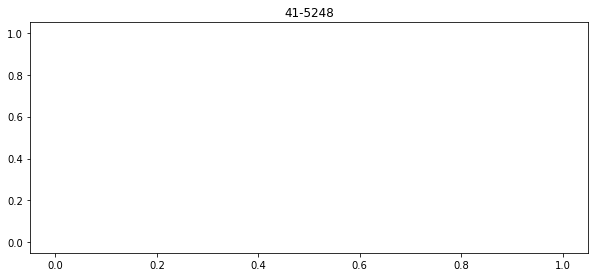

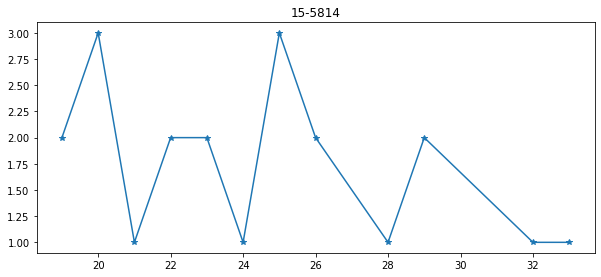

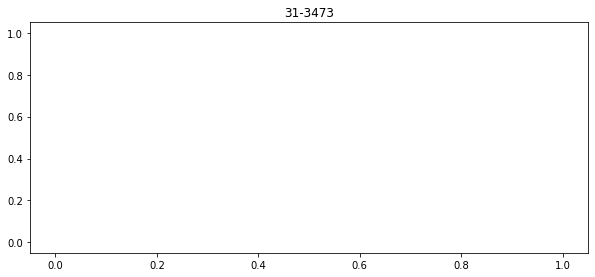

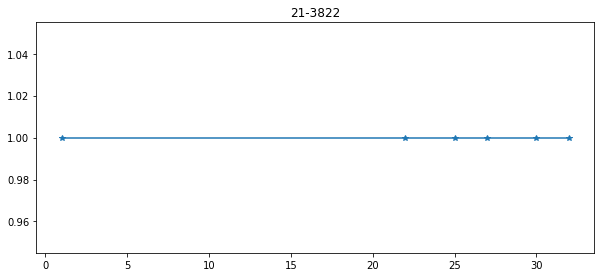

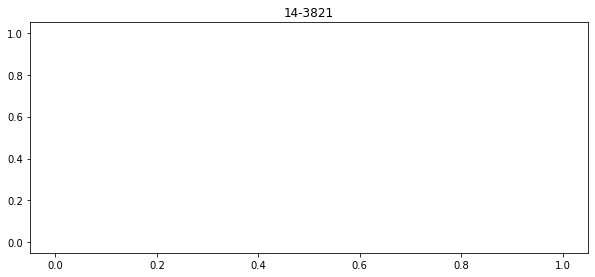

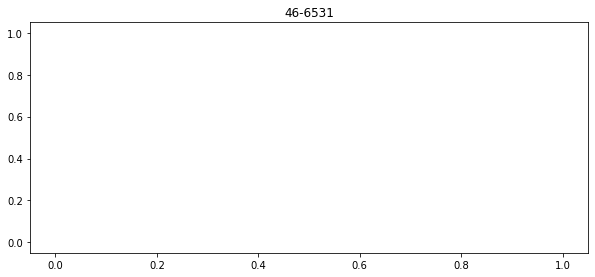

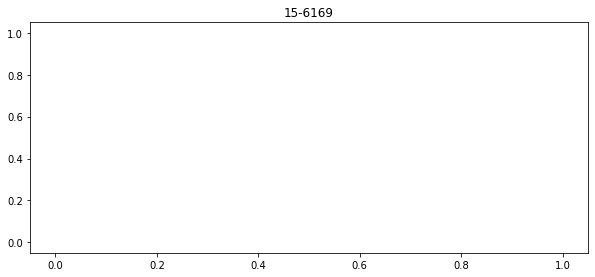

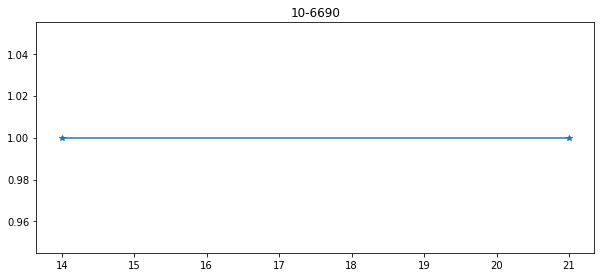

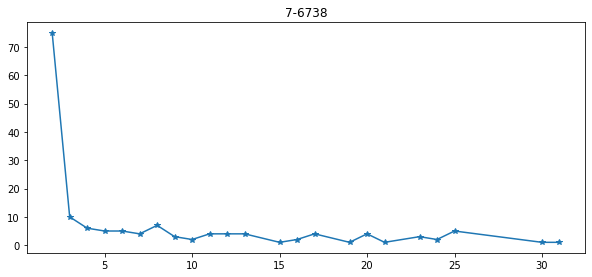

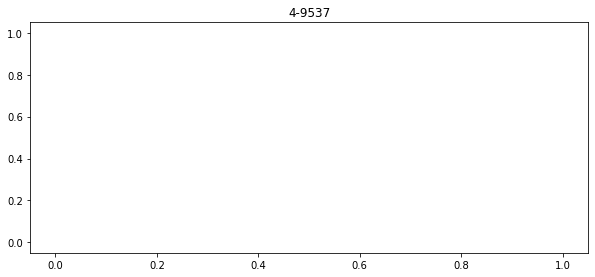

In [8]:
drawTimeSerie(sales_df, sample, n_samples)

# Structure of Data

In [9]:
import featuretools as ft

In [10]:
month_id = 33

In [11]:
sales_month_df = sales_df[sales_df['date_block_num'] == month_id]

In [12]:
sales_month_df['ID_pair'] = sales_month_df[['shop_id','item_id']].apply(lambda x: str(x[0]) + '-' + str(x[1]), axis=1)

In [13]:
sales_month_df.drop(labels=['shop_id'], inplace=True, axis=1)

In [14]:
ids_df = pd.DataFrame(sales_month_df['ID_pair'].unique()).reset_index()

In [15]:
ids_df.columns = ['ids_id','ID_pair']

In [16]:
ids_inverse_dict = ids_df.set_index(keys='ID_pair').to_dict()['ids_id']

In [17]:
sales_month_df['ids_id'] = sales_month_df['ID_pair'].apply(lambda x: ids_inverse_dict[x])

In [18]:
sales_month_df.drop(labels=['ID_pair'], inplace=True, axis=1)

In [30]:
sales_month_df.head()

,index,date_block_num,item_id,item_price,item_cnt_day,ids_id
2882335,2882335,33,13315,649.0,1.0,0
2882336,2882336,33,13880,229.0,1.0,1
2882337,2882337,33,13881,659.0,1.0,2
2882338,2882338,33,13881,659.0,1.0,2
2882339,2882339,33,13923,169.0,1.0,3


In [25]:
entities = {
    'ids'   : (ids_df, 'ids_id'),
    'sales' : (sales_month_df, 'index'),
    'items' : (items_df, 'item_id')
}

In [26]:
relationships = [('ids','ids_id','sales','ids_id'),
                 ('items', 'item_id', 'sales', 'item_id')]

In [27]:
feature_matrix_customers, features_defs = ft.dfs(entities=entities,
                                                relationships=relationships,
                                                target_entity='ids')

In [29]:
feature_matrix_customers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 31531 entries, 0 to 31530
Data columns (total 28 columns):
ID_pair                               31531 non-null object
SUM(sales.date_block_num)             31531 non-null int64
SUM(sales.item_price)                 31531 non-null float64
SUM(sales.item_cnt_day)               31531 non-null float64
STD(sales.date_block_num)             9711 non-null float64
STD(sales.item_price)                 9711 non-null float64
STD(sales.item_cnt_day)               9711 non-null float64
MAX(sales.date_block_num)             31531 non-null int64
MAX(sales.item_price)                 31531 non-null float64
MAX(sales.item_cnt_day)               31531 non-null float64
SKEW(sales.date_block_num)            4453 non-null float64
SKEW(sales.item_price)                4453 non-null float64
SKEW(sales.item_cnt_day)              4453 non-null float64
MIN(sales.date_block_num)             31531 non-null int64
MIN(sales.item_price)                 31531 non-nu

# End of Case! 

In [37]:
feature_matrix_customers[['ID_pair','COUNT(sales)']][feature_matrix_customers['COUNT(sales)'] > 6]

,ID_pair,COUNT(sales)
ids_id,,
146,45-20949,12
203,46-1583,7
381,44-20949,11
406,44-22088,7
470,45-10201,9
471,45-10202,8
570,46-10201,7
683,46-10207,7
691,46-10202,10
